# Laboratorium 4

Zaimplementować funkcję softmax dla warstwy wyjściowej sieci neuronowej. Sprawdzić szybkość i skuteczność w wariancie, gdy sieć używa funkcji softmax na ostatniej warstwie i gdy jest użyta zwykła funkcja aktywacji. **Softmax wymaga też odpowiednich zmian w algorytmie uczenia, uwzględniających pochodną fukcji.**

Przeprowadzić eksperymenty na zbiorach:

    rings3-regular,
    easy,
    xor3.




In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
import matplotlib
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

## Klasa mlp

In [65]:
class MLP:
    """
    layers - wektor zawierający liczbę kolejnych neuronów warstwach, w tym wejscie i wyjscie
    weights_biases - wybor metody losowania wag
    activation_function - funkcja aktywacji
    activation_function_dev - pochodna funkcja aktywacji
    delta_w, delta_b - zmiana biasu i wag w propagacji wstecznej
    softmax_metod - zastosowanie softmax na ostatniej warstwie
    """
    
    
    def __init__(self, layers, weights_biases, activation_function, softmax_method = False):
        self.layers = layers
        self.softmax_method = softmax_method
        self.weights = []
        self.biases = []
        self.delta_w = []
        self.delta_b = []
        
        if activation_function == "sigmoid":
            self.activation_function = self.sigmoid
            self.activation_function_der = self.sigmoid_der

        if weights_biases == "Random":
            self.weights_random()
        elif weights_biases == "Xavier": 
            self.weights_xavier()
        
    def weights_random(self):
        """
        losowanie wag z rozkladu jednostajnego z przedzialu [-1,1] 
        """
        for i in range(len(self.layers) - 1):
            self.weights.append(np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))
            
    def weights_xavier(self):
        """
        losowanie wag metodą Xaviera
        """
        xavier = np.sqrt(6)/np.sqrt(self.layers[1]+self.layers[-1])
        for i in range(len(self.layers) - 1):
            self.weights.append(xavier * np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(xavier * np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))

    
    def forward(self, inputs):
        """
        przejscie do przodu po sieci 
        """
        self.A = []
        self.z = []

        a = inputs
        self.A.append(a)
        for i in range(len(self.layers)-2):

            outputs = a @ self.weights[i] + self.biases[i]
            self.z.append(outputs)
            a = self.activation_function(outputs)
            self.A.append(a)
        results = a @ self.weights[-1] + self.biases[-1]
        if self.softmax_method:
            results = self.softmax(results)
        self.z.append(results)
        self.A.append(results)
        return results

    def backward(self, y):
        """
        propagacja wsteczna
        """
        m = y.shape[0]
        D = [None] * len(self.weights)
        
        if self.softmax_method:
            temp = []
            for a, y_ in zip(self.A[-1], y):
                error = y_ - a
                a_ = a.reshape(a.shape[0], )
                si_sj = - a_ * a_.reshape(self.layers[-1], 1)
                sof_der = np.diag(a_) + si_sj
                temp.append(sof_der @ error)

            temp = np.array(temp)
            D[-1] = temp
        
        else:
            D[-1] = (y - self.A[-1]) * self.activation_function_der(self.A[-1])
        
        
        for i in reversed(range(len(D) - 1)):
            D[i] = ((self.weights[i + 1] @ D[i + 1].T ) * self.activation_function_der(self.z[i]).T).T

        delta_b = [None] * len(D)
        delta_w = [None] * len(D)
        
        for i, d in enumerate(D):
            delta_w[i] = (d.T @ self.A[i]).T / m
            delta_b[i] = (d.T @ np.ones((m, 1))).T / m

        return delta_w, delta_b

    def learn(self, x, y, batch_size=20, iterations=500, alpha=0.01, method = "Classic", var=0.4):
        """
        alpha - learning rate
        method - wybór metody uczenia Classic(default)/Momentum/RMSProp
        var - współczynnik wygaszania
        """
        
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]
        
        method_w = [np.zeros(w.shape) for w in self.weights]
        method_b = [np.zeros(b.shape) for b in self.biases]

        for iteration in range(iterations):
            i = 0
            
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward(x_batch)
                delta_w, delta_b = self.backward(y_batch)
                
                if method == "Classic":
                    for j, weight in enumerate(self.weights):    
                        self.weights[j] = weight + alpha * delta_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        self.biases[j] = bias + alpha * delta_b[j]   
                
                elif method == "Momentum":
                    for j, weight in enumerate(self.weights):    
                        method_w[j] = method_w[j] * var + delta_w[j]
                        self.weights[j] = weight + alpha * method_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = method_b[j] * var + delta_b[j]
                        self.biases[j] = bias + alpha * method_b[j]
                        
                elif method == "RMSProp":
                    for j, weight in enumerate(self.weights):    
                        method_w[j] = var * method_w[j] + (1-var) * delta_w[j] ** 2
                        self.weights[j] = weight + alpha * (delta_w[j]/np.sqrt(method_w[j]) + 10**-8)
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = var * method_b[j] + (1-var) * delta_b[j] ** 2
                        self.biases[j] = bias + alpha * (delta_b[j]/np.sqrt(method_b[j]) + 10**-8)
    
    def classify(self,x):
        probability = self.forward(x)
        return [i.argmax() for i in probability]
    
    
    @staticmethod
    def sigmoid(x):
        z = np.array(x)
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def sigmoid_der(x):
        return MLP.sigmoid(x) * (1 - MLP.sigmoid(x))
    
    @staticmethod
    def softmax(x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T



## Rings3 regular

In [66]:
train_df = pd.read_csv('mio_data/classification/rings3-regular-training.csv')
test_df = pd.read_csv('mio_data/classification/rings3-regular-test.csv')

x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [67]:
layers = [2, 64, 64, 3]
mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = False)

mlp.learn(x = x, y = encoded, alpha = 0.01, iterations = 1000)

mlp_softmax = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = True)

mlp_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = 1000)

Text(0.5, 1.0, 'Softmax')

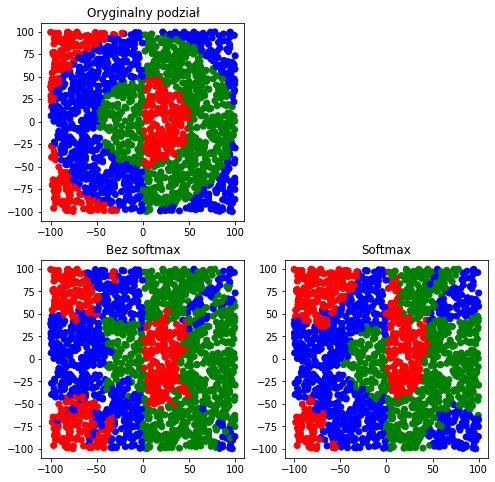

In [68]:
colors = ['red','green','blue']

fig = plt.figure(figsize=(8,8))

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=test_df['c'], cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Oryginalny podział')

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c= mlp.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Bez softmax')

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c= mlp_softmax.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Softmax')


In [69]:
print("Softmax:",accuracy_score(test_df['c'], mlp_softmax.classify(x_test)),
"\nBez softmax:",accuracy_score(test_df['c'], mlp.classify(x_test)))

Softmax: 0.803 
Bez softmax: 0.757


Funkcja z softmaxem poradziła sobie lepiej, a patrząc na trudność zbioru, to całkiem dobrze.

## Xor3 

In [70]:
train_df = pd.read_csv('mio_data/classification/xor3-training.csv')
test_df = pd.read_csv('mio_data/classification/xor3-test.csv')

x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [71]:
layers = [2, 20, 2]
mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = False)

mlp.learn(x = x, y = encoded, alpha = 0.01, iterations = 3000, method = "Momentum", var =0.5)

mlp_softmax = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = True)

mlp_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = 3000, method = "Momentum", var =0.5)

Text(0.5, 1.0, 'Softmax')

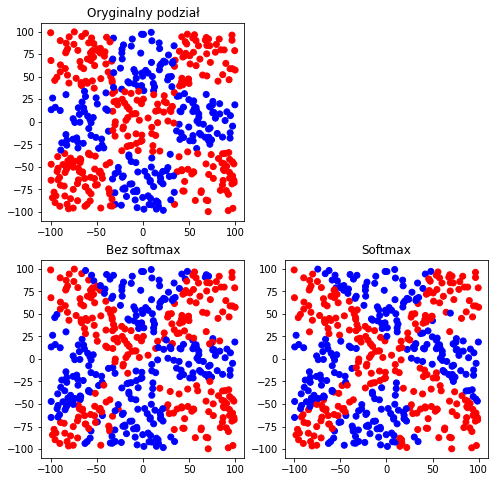

In [72]:
colors = ['red','green','blue']

fig = plt.figure(figsize=(8,8))

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=test_df['c'], cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Oryginalny podział')

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c= mlp.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Bez softmax')

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c= mlp_softmax.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Softmax')

In [73]:
print("Softmax:",accuracy_score(test_df['c'], mlp_softmax.classify(x_test)),
"\nBez softmax:",accuracy_score(test_df['c'], mlp.classify(x_test)))

Softmax: 0.778 
Bez softmax: 0.768


Zbiór dużo łatwiejszy, oba modele poradziły sobie w zadawalającym stopniu.

## Easy

In [74]:
train_df = pd.read_csv('mio_data/classification/easy-training.csv')
test_df = pd.read_csv('mio_data/classification/easy-test.csv')

x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [75]:
layers = [2, 20, 2]
mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = False)

mlp.learn(x = x, y = encoded, alpha = 0.01, iterations = 100, method = "Momentum", var =0.5)

mlp_softmax = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = True)

mlp_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = 100, method = "Momentum", var =0.5)

Text(0.5, 1.0, 'Softmax')

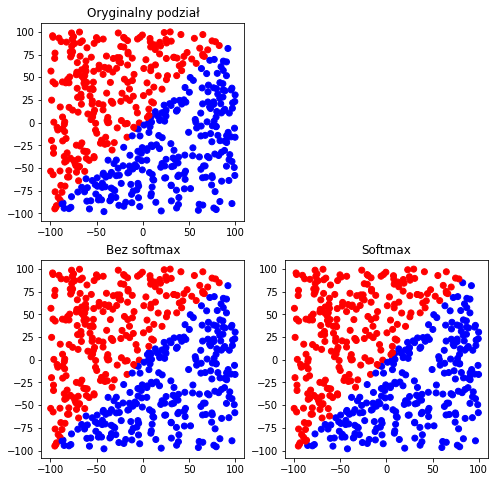

In [76]:
colors = ['red','green','blue']

fig = plt.figure(figsize=(8,8))

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=test_df['c'], cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Oryginalny podział')

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c= mlp.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Bez softmax')

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c= mlp_softmax.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Softmax')

In [77]:
print(accuracy_score(test_df['c'], mlp_softmax.classify(x_test)),
accuracy_score(test_df['c'], mlp.classify(x_test)))

0.992 0.996


Jak widać zbiór jest bardzo łatwy, więc oba modele poradziły sobie bardzo dobrze.